# Machine learning concepts in Chemistry

<a rel="license" href="https://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Author**: Antonia Mey    
**Email**: antonia.mey@ed.ac.uk

Content is partially adapted from the [Software Carpentries Machine learning lesson](https://carpentries-incubator.github.io/machine-learning-novice-sklearn/index.html) and [here](https://github.com/christianversloot/machine-learning-articles/blob/main/performing-dbscan-clustering-with-python-and-scikit-learn.md).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Working with linear regressions

As an example, let's take some scattered data (green points below). We want to fit a linear model (blue line) through them. By eye, we can see that a line at $y = 0$ does not fit the data well. 
<img src="images/scatter_data.png" alt="drawing" width="300"/>

Each green point is located at a certain distance from the blue line. We call this distance a **residual**. A good fit leads to small residuals.
<img src="images/initial_guess.png" alt="drawing" width="300"/>

We can quantify how well a line fits the data by calculating the **Mean square error (MSE)**. The MSE is a *second order polynomial* is defined as:

$\mathrm{MSE} = \frac{1}{n}\sum(Y_i - \hat Y_i)^2$

$n$ is the number of data points,   
$Y_i$ is the observed value (i.e. the measured data point),   
$\hat Y_i$ is the predicted value (i.e. the value that lies on the line of best fit).   

To find the line of best fit, we need to find which combination of its parameters (for a linear function, slope and intercept) leads to the smallest MSE.

<img src="images/best_fit_loss.png" alt="drawing" width="300"/>

 How do we minimise a function again?

### 1.1 Finding the minimum of a function

      fun: 1.7831480697457274e-16
 hess_inv: array([[1.00000001]])
      jac: array([-1.1434059e-08])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([1.99999998])
      fun: 6.310886216248959e-14
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.60271339e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([2.00000036])


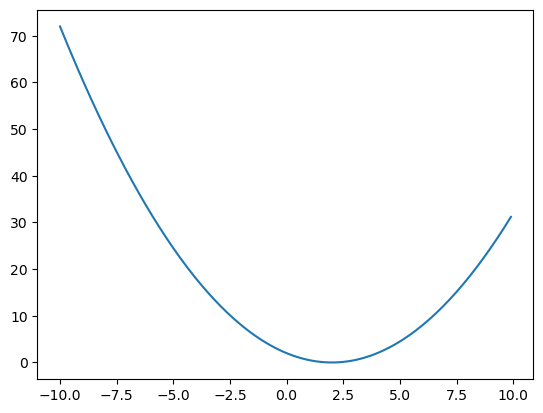

In [6]:
from scipy import optimize
def f(r):
    return 0.5*(r-2)**2

# defining the r values
r = np.arange(-10,10,0.1)
plt.plot(r, f(r))
print(optimize.minimize(f, x0=4))

# Trying with a different method and starting point
print(optimize.minimize(f, x0=7, method="L-BFGS-B"))

### 1.2 Linear regression

In order to find the line of best fit, we need to find the minimum of the $\mathrm{MSE}$ function. Now the issue that this function does not depend on a single $x$ anymore, but many different values! Remember we are trying to find a line of the following form $y = mx+b$

In [9]:
from scipy import stats
data = pd.read_csv('data/sodium_data.dat', delimiter='\t')
temp = data.iloc[:, 1].to_list()
solubility = data.iloc[:, 2].to_list()
res = stats.linregress(temp,solubility)

Text(0, 0.5, 'Solubility/mole/l')

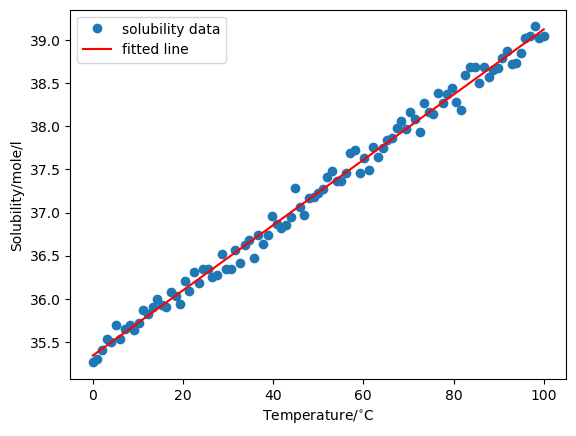

In [10]:
plt.plot(temp, solubility, 'o', label='solubility data')
plt.plot(np.array(temp), res.intercept + res.slope*np.array(temp), 'r', label='fitted line')
plt.legend()
plt.xlabel('Temperature/$^{\circ}$C')
plt.ylabel('Solubility/mole/l')

## 2. Dimensionality reduction

### 2.1 The Müller Brown Potential

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is an orthogonal linear transformation that transforms high dimensional data (or feature vectors) into a new coordinate system. In this coordinate system the first coordinate (first *eigenvector*) corresponds to the scalar projection of a linear combination of some data such that this coordinate has the largest variance. The second largest variance in the data can be found in the second coordinate and so on. Let's start by importing some packages required for the our analysis.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Now, let's create some model data to analyse. To this end, we will exploit the Müller-Brown potential.

In [13]:
def muller_potential(x, y):
    """Muller potential
    
    Parameters
    ----------
    x : {float, np.ndarray}
        X coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    y : {float, np.ndarray}
        Y coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    Returns
    -------
    potential : {float, np.ndarray}
        Potential energy. Will be the same shape as the inputs, x and y.
    
    Reference
    ---------
    Code adapted from https://cims.nyu.edu/~eve2/ztsMueller.m
    """
    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value




We will now evaluate the potential on a 2-D grid, and plot visualize it.

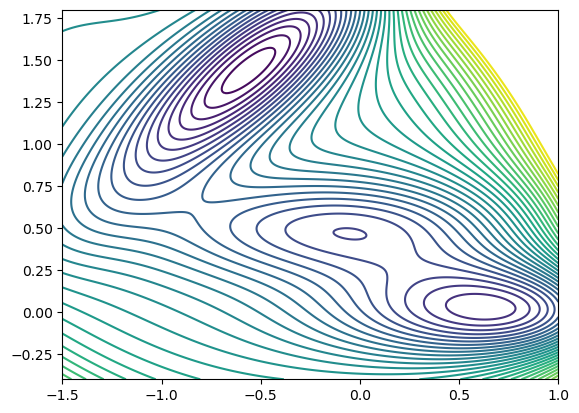

In [14]:
dims = (500, 500)
x = np.linspace(-1.5, 1, dims[0])
y = np.linspace(-0.4, 1.8, dims[1])
X, Y = np.meshgrid(x, y)
potential = muller_potential(X, Y)

levels = np.linspace(np.min(potential), np.max(potential), 50)
plt.contour(X, Y, potential.clip(max=200), 40);

Now, let's convert our potential into a probability distribution, and plot the result.

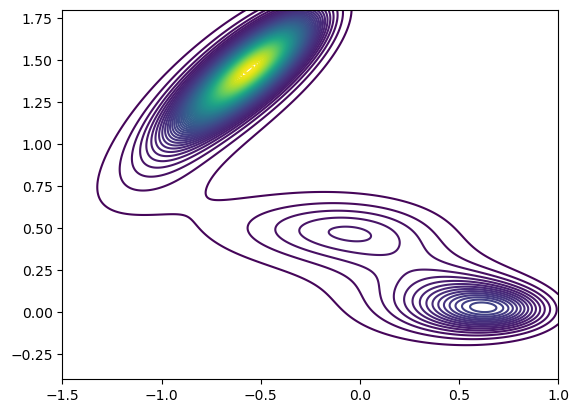

In [15]:
Z = np.sum(np.exp(-1/25*potential)) #partition function
P = np.exp(-1/25*potential)/Z

plt.contour(X, Y, P, 100);

It's time to generate some data! We will extract 10000 samples according to the probability distribution we have just created. To this end, we will use np.random.choice, which enables us to generate random samples according to a given probability. Since this method works only in 1-D, we will first flatten the array, generate the samples, and them bring them back to 2-D.



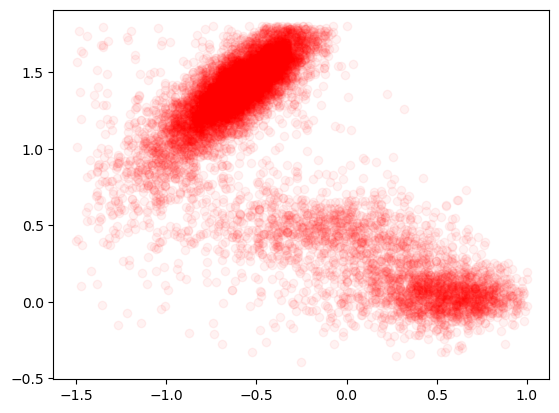

In [16]:
flat = np.ravel(P)
sample_index = np.random.choice(a=flat.size, p=flat, size=10000)
samples = np.unravel_index(sample_index, P.shape)
data = np.array([x[samples[1]], y[samples[0]]]).T

plt.scatter(data[:, 0], data[:, 1], c="r", alpha=0.05);

PCA can tell us in which features (here the x coordinate is one feature and the y coordinate is the second feature), or rather which linear combination, carries the most variance. Let's do a PCA of the samples we have created.

In [17]:
pca = PCA(n_components=2)
pca.fit(data)

PCA(n_components=2)

PCA has identified the two eigenvectors (principal components) of our dataset. Here they are:

In [18]:
print(pca.components_)

[[ 0.62381988 -0.78156814]
 [-0.78156814 -0.62381988]]


Each component represents a percentage of the total variance of the system. Here is how:

In [19]:
print(pca.explained_variance_ratio_)

[0.84302414 0.15697586]


It is clear that the first component represents majority of the variance in the data. We have identified the two eigenvectors of this dataset. We can now plot them along with the data. To make arrows visible, we will scale their length by the explained variance of each eigenvector.




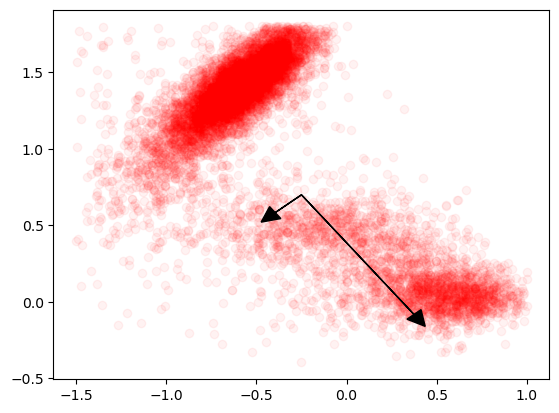

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data[:,0], data[:,1], c="r", alpha=0.05)

# plot arrows representing the two components
e1_x = pca.components_[0, 0]*pca.explained_variance_ratio_[0]
e1_y = pca.components_[0, 1]*pca.explained_variance_ratio_[0]
e2_x = pca.components_[1, 0]*pca.explained_variance_ratio_[1]
e2_y = pca.components_[1, 1]*pca.explained_variance_ratio_[1]
ax.arrow(np.mean(x), np.mean(y), e1_x/pca.explained_variance_ratio_[0], e1_y/pca.explained_variance_ratio_[0], head_width=0.1, head_length=0.1, fc='k', ec='k')
ax.arrow(np.mean(x), np.mean(y), e2_x/pca.explained_variance_ratio_[0], e2_y/pca.explained_variance_ratio_[0], head_width=0.1, head_length=0.1, fc='k', ec='k');

In [21]:
data_projected = data.dot(pca.components_) + pca.mean_
print(data_projected)

[[-1.96428486  0.42076735]
 [-1.83872161  1.0338047 ]
 [-1.22271558  0.82035512]
 ...
 [-0.35299856  0.5081285 ]
 [-0.09632454  0.53992076]
 [-1.60737502  1.36589227]]


### 2.2 PCA with the MNIST Dataset
The MNIST dataset consists of a 60,000 examples of hand written numbers and 10,000 test set examples. The digits have all been resized to the same size and centered within this fixed image size. One way of accessing the data is from [here](http://yann.lecun.com/exdb/mnist/) or we can use built in function with scikit-learn. In this way you will access a reduced part of the dataset.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import datasets
from sklearn import manifold

digits = datasets.load_digits()

# Examine the dataset
print(digits.data)
print(digits.target)

X = digits.data
y = digits.target

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


A short helper function to plot an example from the dataset:

In [25]:
def plot_digits(X):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((8, 8)), cmap="Greys")
        ax.axis("off")

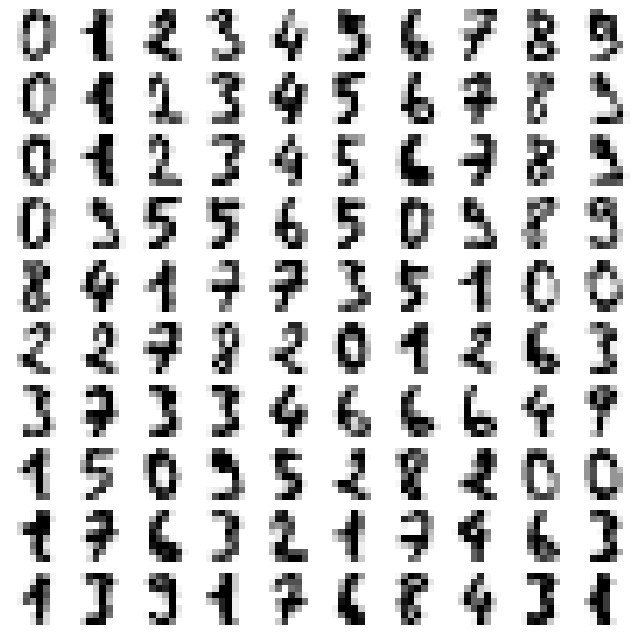

In [26]:
plot_digits(X)

PCA of the MNIST dataset:

[0.14890594 0.13618771]
21 number of principle components are needed to reach a variance explained of 90%


Text(0, 0.5, 'pc 2')

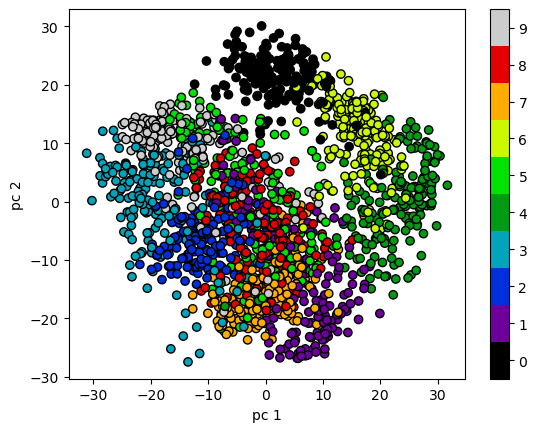

In [27]:
# PCA
pca = decomposition.PCA(n_components=2, n_oversamples=20)
pca.fit(X)
X_pca = pca.transform(X)

# variance contribution of first two components 
print(pca.explained_variance_ratio_)

# finding 90% variance
for i in range(2,30):
    pca = decomposition.PCA(n_components=i, n_oversamples=20)
    pca.fit(X)
    X_pca = pca.transform(X)
    cum_sum = pca.explained_variance_ratio_.cumsum()
    if cum_sum[-1] > 0.9:
        print(f'{i} number of principle components are needed to reach a variance explained of 90%')
        break

# plotting first two components and colouring according to digits
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.nipy_spectral, 
        edgecolor='k',label=y)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel('pc 1')
plt.ylabel('pc 2') 